Two reference sources:

https://colab.research.google.com/github/criteo/autofaiss/blob/master/docs/notebooks/autofaiss_multimodal_search.ipynb

https://github.com/rom1504/clip-retrieval/issues/264



In [21]:
from io import BytesIO

import clip
import numpy as np
import pandas as pd
import requests
import torch
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

# embeddings: https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/img_emb/img_emb_0.npy
# parquet: https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/metadata/metadata_0.parquet


Download sample clip embedding and metadata for building sample index (this takes only few minutes)

In [ ]:
!aria2c https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/img_emb/img_emb_0.npy
!aria2c https://deploy.laion.ai/8f83b608504d46bb81708ec86e912220/embeddings/metadata/metadata_0.parquet

In [1]:
!mkdir embeddings
!mv img_emb_0.npy metadata_0.parquet embeddings/

In [2]:
!ls embeddings

img_emb_0.npy  metadata_0.parquet


In [6]:
## Build sample Index
!autofaiss build_index --embeddings="embeddings" \
                    --index_path="knn.index" \
                    --index_infos_path="infos.json" \
                    --metric_type="ip" \
                    --max_index_query_time_ms=5 \
                    --max_index_memory_usage="1GB"

2023-06-06 08:20:24,276 [INFO]: Using 96 omp threads (processes), consider increasing --nb_cores if you have more
2023-06-06 08:20:24,277 [INFO]: Launching the whole pipeline 06/06/2023, 08:20:24
2023-06-06 08:20:24,277 [INFO]: Reading total number of vectors and dimension 06/06/2023, 08:20:24
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 367.44it/s]
2023-06-06 08:20:24,320 [INFO]: There are 1000448 embeddings of dim 512
2023-06-06 08:20:24,321 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0438 secs
2023-06-06 08:20:24,321 [INFO]: 	Compute estimated construction time of the index 06/06/2023, 08:20:24
2023-06-06 08:20:24,321 [INFO]: 		-> Train: 16.7 minutes
2023-06-06 08:20:24,321 [INFO]: 		-> Add: 5.7 seconds
2023-06-06 08:20:24,321 [INFO]: 		Total: 16.8 minutes
2023-06-06 08:20:24,322 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0006 secs
2023-06-06 08:20:24,322 [INFO]: 	Checking that your have enough 

In [7]:
!ls knn.index

knn.index


In [8]:
# Load index
import faiss
import numpy as np
ind = faiss.read_index("knn.index")

In [31]:
from pathlib import Path
import pandas as pd
data_dir = Path("embeddings")
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print(df.head(2))
image_list = df["image_path"].tolist()
caption_list = df["caption"].tolist()
url_list = df["url"].tolist()

  image_path                                            caption      NSFW  \
0  000000033  2 bed Terraced property to rent in Crofts Lane...  UNLIKELY   
1  000000044  Teleflora's Simply Sweet in Cleveland TN, Jimm...  UNLIKELY   

   similarity LICENSE                                                url  key  \
0    0.333244       ?  http://media.rightmove.co.uk/dir/87k/86030/419...   33   
1    0.301415       ?  http://images.shopflowers.net/images/products/...   44   

   shard_id   status error_message  width  height exif  original_width  \
0     19848  success          None    256     256   {}             191   
1     19848  success          None    256     256   {}             274   

   original_height  
0              143  
1              300  


Sample image query within same dataset
check cosine similarity, note that the score might not be perfect due to slightly different preprocessing 

Pre-norm difference: -4.477
Post-norm difference: 0.1812
Cosine sim: [[0.90330808]]
Query :
caption = 2 bed Terraced property to rent in Crofts Lane, Ross-on-Wye


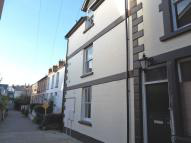

Results :
Similarity=  1.0034864
Index =0
Caption =2 bed Terraced property to rent in Crofts Lane, Ross-on-Wye
 
Similarity=  0.9329858
Index =178870
Caption =Meadow Street End of Terrace property for sale
 
Similarity=  0.9278207
Index =542194
Caption =Terraced property for sale in Hardy Road, Bedminster...
 
Similarity=  0.9147655
Index =320130
Caption =5 bed Terraced house to rent in Norfolk Road, Falmouth...
 
Similarity=  0.9139611
Index =571482
Caption =Terraced home for sale in Newcomen Terrace, Redcar
 
Similarity=  0.9112031
Index =696696
Caption =2 bed Apartment to rent in Pleasant Row, Gillingham...
 
Similarity=  0.908084
Index =343865
Caption =Thumbnail 2 bedroom detached house to rent in Western Terrace, Barnstaple
 
Similarity=  0.905835
Index =55183
Caption =Thumbnail Commercial property for sale in North Parade, Penzance, Cornwall
 
Similarity=  0.9053878
Index =84834
Caption =Terraced property in Zetland Street Darlington
 
Similarity=  0.9029571
Index =578131
Caption

In [28]:
INDEX = 0

laion_embedding = np.load("./embeddings/img_emb_0.npy")[INDEX]
laion_embedding = np.expand_dims(laion_embedding, 0)
url = pd.read_parquet("./embeddings/metadata_0.parquet")["url"][INDEX]
caption = pd.read_parquet("./embeddings/metadata_0.parquet")["caption"][INDEX]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

response = requests.get(url)
imageIO = Image.open(BytesIO(response.content))
image = preprocess(imageIO).unsqueeze(0).to(device)

with torch.no_grad():
    clip_embedding = model.encode_image(image).cpu().numpy()


print("Pre-norm difference:", (laion_embedding - clip_embedding).sum())
clip_embedding = clip_embedding / np.linalg.norm(clip_embedding)
print("Post-norm difference:", (laion_embedding - clip_embedding).sum())
print("Cosine sim:", cosine_similarity(laion_embedding, clip_embedding))


# from IPython.display import Image
print("="*10)
print("Query :")
print("caption = {}".format(caption))
display(imageIO) 


# D, I = ind.search(np.expand_dims(ind.reconstruct(image_number), 0), 5)
D, I = ind.search(laion_embedding, 10)
print("="*10)
print("Results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print(" ")

Pre-norm difference: -0.2494
Post-norm difference: 0.708
Cosine sim: [[0.9258284]]
Query :
caption = T-shirt Skullactic Wave  - Charcoal


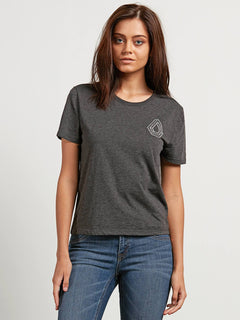

Results :
Similarity=  1.0006417
Index =10
Caption =T-shirt Skullactic Wave  - Charcoal
 
Similarity=  0.88807654
Index =63529
Caption =Lauren Moshi Edda Crystal Rainbow Lip Vintage Tee in Black
 
Similarity=  0.880788
Index =674781
Caption =Long sleeves button blouse - 16122
 
Similarity=  0.87759
Index =198165
Caption =CeCe Bow Neck Short Sleeve Sweater   Nordstrom at Nordstrom
 
Similarity=  0.8763025
Index =806491
Caption =Empyre Diaz Crochet Pocket Black Dolman Top
 
Similarity=  0.8737155
Index =623792
Caption =Ruff Hewn GREY Plus Size Cold Shoulder Knit Top
 
Similarity=  0.87196225
Index =804343
Caption =T-shirt coton Maite Kelly, bpc bonprix collection
 
Similarity=  0.8711974
Index =857617
Caption =Camera Every photo has a story Unisex V-Neck
 
Similarity=  0.87000597
Index =292657
Caption =Good Feels Mock Neck Tee, HTHR Fawn | Kit and Ace
 
Similarity=  0.8679854
Index =221303
Caption =Lacoste - T-shirt basic - black
 


In [29]:
INDEX = 10

laion_embedding = np.load("./embeddings/img_emb_0.npy")[INDEX]
laion_embedding = np.expand_dims(laion_embedding, 0)
url = pd.read_parquet("./embeddings/metadata_0.parquet")["url"][INDEX]
caption = pd.read_parquet("./embeddings/metadata_0.parquet")["caption"][INDEX]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

response = requests.get(url)
imageIO = Image.open(BytesIO(response.content))
image = preprocess(imageIO).unsqueeze(0).to(device)

with torch.no_grad():
    clip_embedding = model.encode_image(image).cpu().numpy()


print("Pre-norm difference:", (laion_embedding - clip_embedding).sum())
clip_embedding = clip_embedding / np.linalg.norm(clip_embedding)
print("Post-norm difference:", (laion_embedding - clip_embedding).sum())
print("Cosine sim:", cosine_similarity(laion_embedding, clip_embedding))


# from IPython.display import Image
print("="*10)
print("Query :")
print("caption = {}".format(caption))
display(imageIO) 


# D, I = ind.search(np.expand_dims(ind.reconstruct(image_number), 0), 5)
D, I = ind.search(laion_embedding, 10)
print("="*10)
print("Results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print(" ")

### Text to image query

In [43]:
text = "White cat with blue eyes"
text_tokens = clip.tokenize([text], truncate=True)

text_features = model.encode_text(text_tokens.to(device))
text_features /= text_features.norm(dim=-1, keepdim=True)
text_embeddings = text_features.cpu().detach().numpy().astype('float32')

print("="*10)
print("text query = {}".format(text))

D, I = ind.search(text_embeddings, 5)
print("results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print("Image url = {}".format(url_list[i]))
  print(" ")

text query = White cat with blue eyes
results :
Similarity=  0.35257193
Index =53913
Caption =cat, white, and eyes image
Image url = https://data.whicdn.com/images/209379605/superthumb.jpg?t=1447926717
 
Similarity=  0.33932382
Index =298919
Caption =Portrait of a  varicoloured eyes white cat
Image url = https://thumbs.dreamstime.com/x/portrait-varicoloured-eyes-white-cat-6288148.jpg
 
Similarity=  0.33197647
Index =751894
Caption =Close up portrait of kitten Rag Doll
Image url = https://media.istockphoto.com/photos/fluffy-kitten-with-blue-eyes-close-up-picture-id1094102386?b=1&k=6&m=1094102386&s=170667a&h=i-eySVqrsUfdbjrSoqe1Nj-cvN7Cz02Rdhw6wUwxmD0=
 
Similarity=  0.3282828
Index =930175
Caption =British shorthair silver kitten
Image url = https://static.wixstatic.com/media/a0115a_701ca1ceaa59411087adc462d6c24979~mv2_d_3008_2000_s_2.jpg
 
Similarity=  0.32673693
Index =713261
Caption =Six Week Old Red Point Siamese Kitten
Image url = http://www.burnthwaitessiamese.co.uk/wp-content/upl

### image to image query

In [41]:
!rm newcat.jpg
!wget 'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F47%2F2021%2F09%2F21%2Fragdoll-owner-holding-cat-1019000674-2000.jpg&q=60' -O newcat.jpg

--2023-06-06 09:00:04--  https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F47%2F2021%2F09%2F21%2Fragdoll-owner-holding-cat-1019000674-2000.jpg&q=60
Resolving imagesvc.meredithcorp.io (imagesvc.meredithcorp.io)... 146.75.50.137
Connecting to imagesvc.meredithcorp.io (imagesvc.meredithcorp.io)|146.75.50.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121898 (119K) [image/jpeg]
Saving to: ‘newcat.jpg’

newcat.jpg          100%[===================>] 119.04K  --.-KB/s    in 0.02s   

2023-06-06 09:00:05 (4.77 MB/s) - ‘newcat.jpg’ saved [121898/121898]



query :


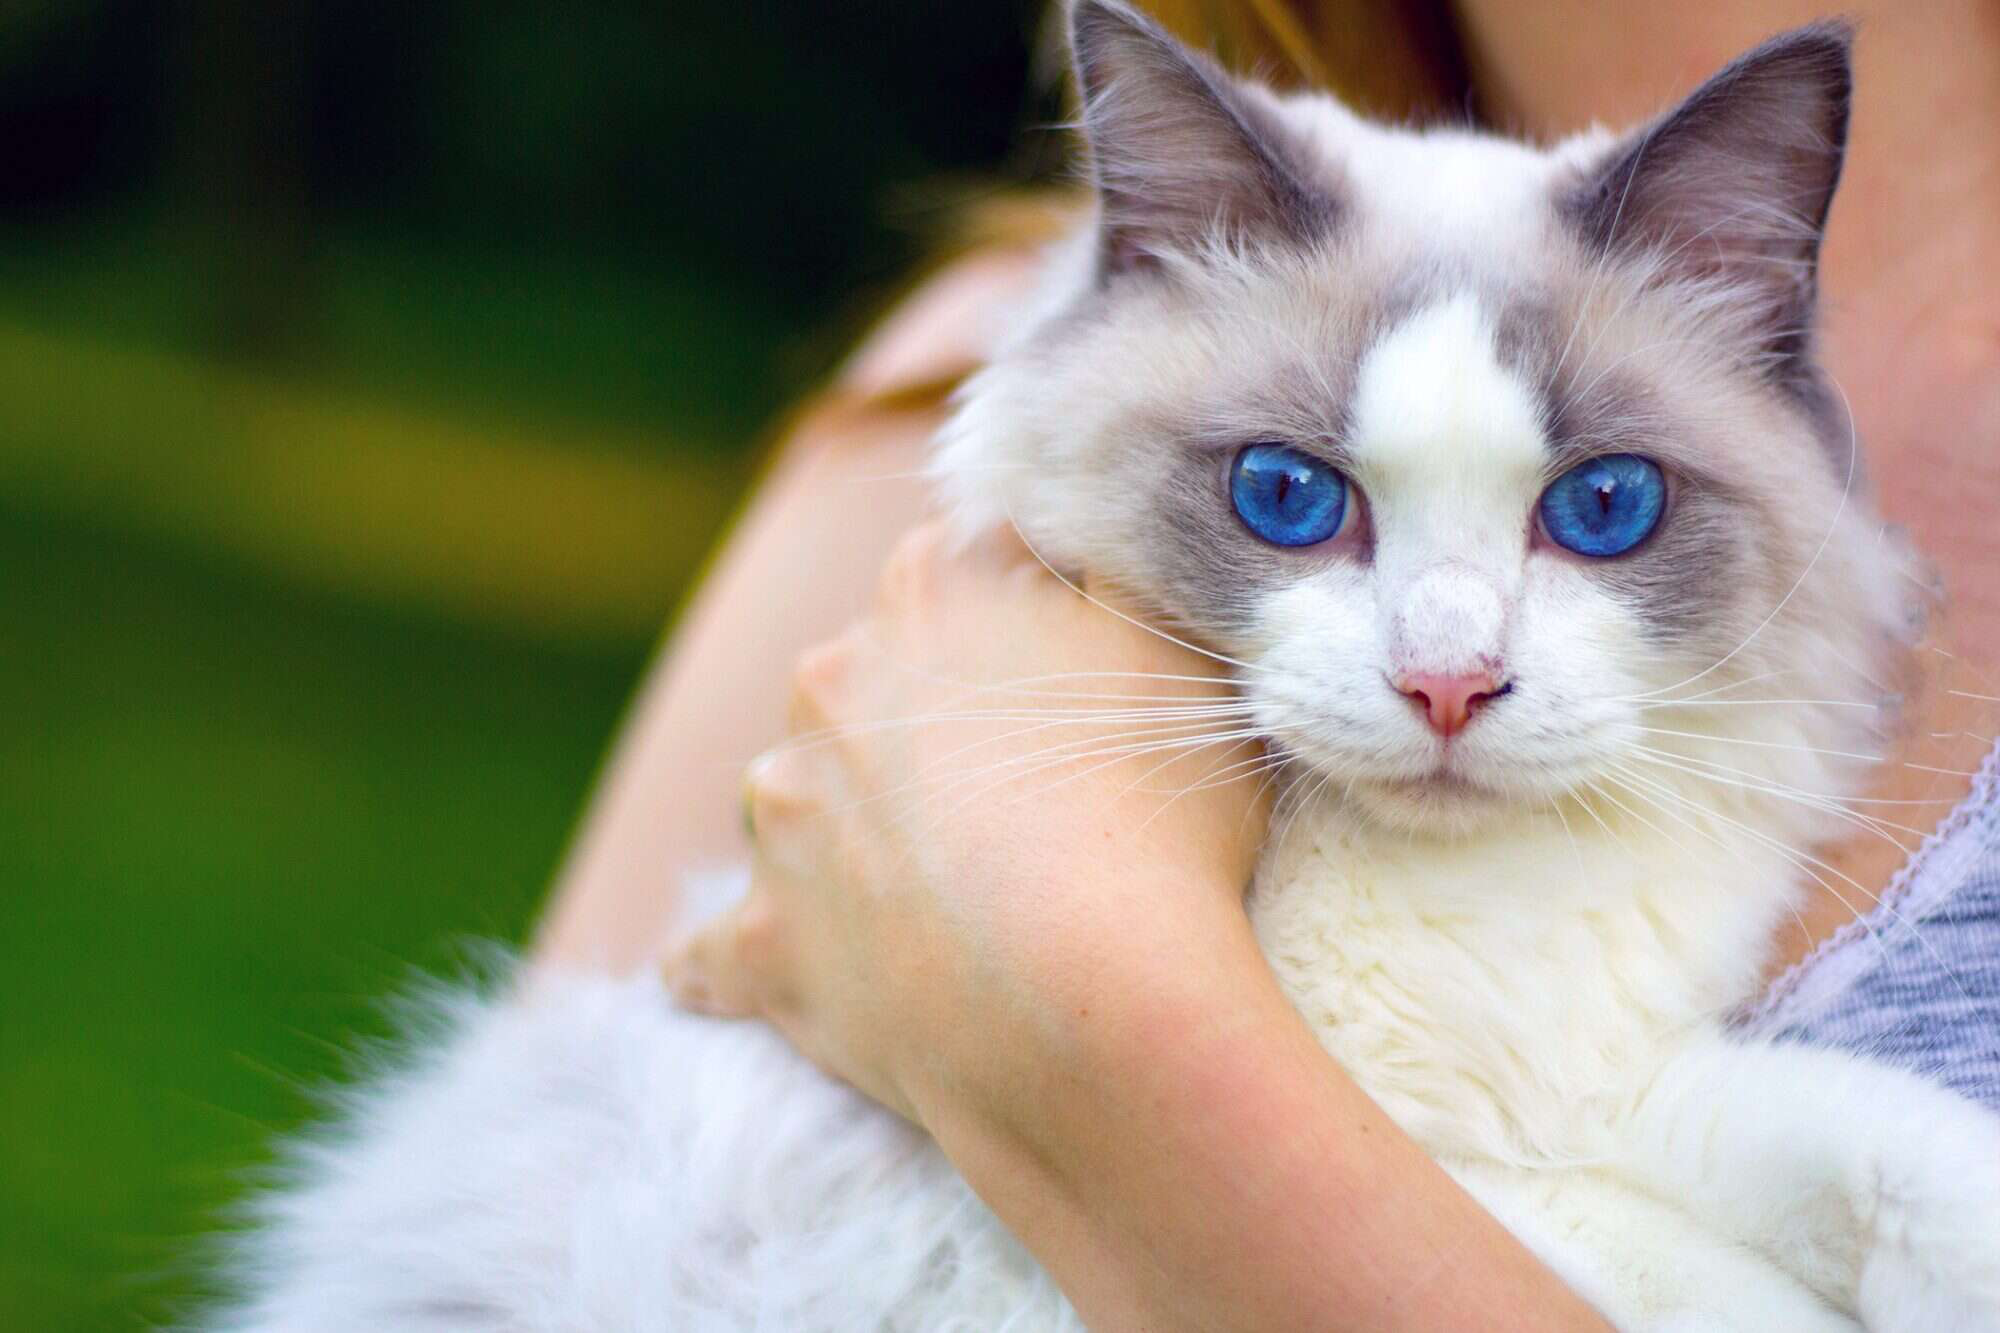

results :
Similarity=  0.84362966
Index =53913
Caption =cat, white, and eyes image
Image url = https://data.whicdn.com/images/209379605/superthumb.jpg?t=1447926717
 
Similarity=  0.8295487
Index =478216
Caption =himalayan cat: Cat isolated over white background
Image url = https://us.123rf.com/450wm/satina/satina1003/satina100301562/6615526-cat-isolated-over-white-background.jpg?ver=6
 
Similarity=  0.82392037
Index =707221
Caption =himalayan cat: Cat isolated Stock Photo
Image url = https://us.123rf.com/450wm/satina/satina1003/satina100300530/6574357-cat-isolated.jpg?ver=6
 
Similarity=  0.8170714
Index =882682
Caption =White Cat Breeds
Image url = https://petsaw.com/wp-content/uploads/2020/04/dreamstime_xxl_13363170_edit.jpg
 
Similarity=  0.8167685
Index =797777
Caption =Male Cat Names For Orange Cats
Image url = https://media.buzzle.com/media/images-en/photos/mammals/cats/1200-60808028-red-kitten.jpg
 


In [42]:
from PIL import Image

image = Image.open("newcat.jpg")
image_tensor = preprocess(image)

image_features = model.encode_image(torch.unsqueeze(image_tensor.to(device), dim=0))
image_features /= image_features.norm(dim=-1, keepdim=True)

image_embeddings = image_features.cpu().detach().numpy().astype('float32')

print("query :")
display(image) 

D, I = ind.search(image_embeddings, 5)
print("results :")
for d, i in zip(D[0], I[0]):
  print("Similarity= ", d)
  print("Index ={}".format(i))
  print("Caption ={}".format(caption_list[i]) )
  print("Image url = {}".format(url_list[i]))
  print(" ")